# Game prototype

In [2]:
from collections.abc import Callable
from abc import ABC, abstractmethod
from dataclasses import dataclass
from typing import TypeVar, Type

from collections import Counter
from IPython.display import Image as IPImage, display, clear_output
from pathlib import Path
from PIL import Image as PImage
from openai import OpenAI
import dspy
import requests

import base64
from io import BytesIO

import logging
import regex

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    filename="app.log",
    filemode="a",
)

CanvasType = PImage.Image | str
QueryType = CanvasType | list[CanvasType]
AlphabetType = dict[str, QueryType] | list[str]  # first str index/name of symbol

In [43]:
global_response_buffer = None # for response
global_alphabet_buffer = None # for query alphabet

In [130]:
# ───────────────────────────────────
# EXAMPLE & TASK
# ───────────────────────────────────

@dataclass
class AlphabetType:

    def __init__(self, alphabet_name:str, indexed_letters:AlphabetType): # self reference
        
        self.alphabet_name = alphabet_name
        self.indexed_letters = indexed_letters


@dataclass
class Example:
    """
    One example puzzle: contains the message to encode,
    the allowed alphabets for encoding, and the alphabet for decoding.
    """

    def __init__(
        self,
        message: QueryType,
        encoder_alphabet: AlphabetType,
        decoder_alphabet: AlphabetType,
        validator_alphabet: AlphabetType,
    ):
        self.message = message
        self.encoder_alphabet = encoder_alphabet
        self.decoder_alphabet = decoder_alphabet
        self.validator_alphabet = validator_alphabet


@dataclass()
class Task:
    """A set of examples forming a complete task."""

    def __init__(
        self,
        examples: list[Example],
        separator: chr,
        description_format: tuple[str, str, str, str],
    ):
        self.examples = examples
        self.separator = separator  # TODO: empty "" for single symbols over alphabet
        (
            self.message_category,
            self.encoder_alphabet_name,
            self.decoder_alphabet_name,
            self.validator_alphabet_name,
        ) = description_format
        """self.encode_description = "\nGiven a {message_category} as query, encode (not necessarily transcribe) it with symbols out of {encoder_alphabet_name}(alphabet). Divide symbols by: '{separator}'".format(
            message_category=self.message_category,
            encoder_alphabet_name=self.encoder_alphabet_name,
            separator=self.separator,
        )"""

        self.encode_description = "\nGiven a {message_category} as query, encode (not necessarily transcribe) it with symbols out of {encoder_alphabet_name}(alphabet).".format(
            message_category=self.message_category,
            encoder_alphabet_name=self.encoder_alphabet_name,
        ) #TODO: just cause seperator and ai doent like ach othwer

        """self.decode_description = "\nGiven a cipher as query decode (not necessarily transcribe) it back to a {message_category} with {decoder_alphabet_name}(alphabet). Divide symbols by: '{separator}".format(
            message_category=self.message_category,
            decoder_alphabet_name=self.decoder_alphabet_name,
            separator=self.separator,
        )"""

        self.decode_description = "\nGiven a cipher as query decode (not necessarily transcribe) it back to a {message_category} with {decoder_alphabet_name}(alphabet).".format(
            message_category=self.message_category,
            decoder_alphabet_name=self.decoder_alphabet_name,
        )

        self.validate_description = "TODO"
        # TODO. ask niklas if sepreator is alwys betwenn chars cause if "" is sepratot emojis and chars are complicated    promlem(if no seprator but alphabeat contain heart and bb)


@dataclass()
class RoundState:
    """
    Stores the intermediate and final results of a single example:
    the cipher and the decoded message(message prime).
    Class used for logging
    """

    def __init__(
        self, example: Example
    ):  # TODO: use, should prevent  seperate alphabet description querey trnsport
        self.example = example
        self.cipher = None
        self.ciphers = []
        self.message_prime = None
        self.message_primes = []


# ───────────────────────────────────
# Signature
# ───────────────────────────────────


class Signature(ABC):
    """Abstract base for all signatures."""

    @abstractmethod
    def check(
        self,
        query: QueryType,
        alphabet: AlphabetType,
    ) -> bool:
        """Check whether the query is valid given the alphabet."""
        pass


class WordsSignature(Signature, ABC):
    """Signature allowing arbitrary combinations of symbols."""

    NAME = "Valid is any word over the alphabet"
    pass


class NWordsSignature(Signature, ABC):
    """Signature restricting words to maximum length n."""

    NAME = "Valid is any word over the alphabet of length n"
    pass


class SingleChoiceSignature(Signature, ABC):
    """Signature restricted to a single symbol."""

    NAME = "Valid is any single choice of the alphabet"
    pass


class MultipleChoiceSignature(Signature, ABC):
    """Signature restricted to a fixed number of symbols."""

    NAME = "Valid is a non repeating choice of four symbols" # n 
    pass


class PermutationsSignature(Signature, ABC):
    """Signature restricted to permutation of the entire alphabet."""

    NAME = "Valid is a permutation of the alphabet"
    pass


class VariationSignature(Signature, ABC):
    """Signature allowing variation of the alphabet."""

    NAME = "Valid is a variation of the alphabet"
    pass


# ───────────────────────────────────
# Adapter
# ───────────────────────────────────


class Adapter(ABC):
    """Interface for human or AI adapter interacting with the game."""

    @abstractmethod
    def present_data(
        self,
        query: QueryType,
        query_alphabet: AlphabetType,
        task_alphabet: AlphabetType,
        signature_name: str,
    ) -> None:
        """Display the query and alphabet to the adapter."""
        pass

    @abstractmethod
    def get_data(self) -> QueryType:
        """Return the adapter's response (cipher or decoded message)."""
        pass


class HumanAdapter(Adapter):
    """adapter interacting with a human user."""

    pass


class AIAdapter(Adapter):
    """adapter interacting with an AI model."""

    pass


# ───────────────────────────────────
# Agent
# ───────────────────────────────────


class Agent(ABC):
    """Handles encoding and communication with an adapter."""

    def __init__(self, signature_cls: Type[Signature], adapter_cls: Type[Adapter]):
        self.signature = signature_cls()
        self.adapter = adapter_cls()

    @abstractmethod
    def ask_adapter_for_query(
        self, query: QueryType, query_alphabet: AlphabetType, task_alphabet: AlphabetType
    ) -> QueryType:
        """Run the adapter to produce a query."""
        pass

    @abstractmethod
    def verify_query_with_signature(
        self, query: QueryType, alphabet: AlphabetType
    ) -> bool:
        """Check if the produced query is valid."""
        pass


# ───────────────────────────────────
# GAME
# ───────────────────────────────────


class Game(ABC):
    """Game logic handling transmission, validation, and communication."""

    def __init__(
        self,
        task: Task,
        signature_encoder_cls: tuple[Type[Signature], Type[Adapter]],
        signature_decoder_cls: list[tuple[Type[Signature], Type[Adapter]]],
        signature_validator_cls: tuple[Type[Signature], Type[Adapter]],
        agent_cls: Type[Agent],
    ):
        self.task = task

        self.agent_sender = agent_cls(*signature_encoder_cls)

        self.agent_receivers = [agent_cls(*t) for t in signature_decoder_cls]

        self.agent_validator = agent_cls(*signature_validator_cls)

        self.points = {r: 0 for r in self.agent_receivers}

    @abstractmethod
    def call_agent(
        self, agent: Agent, query: QueryType, query_alphabet: AlphabetType, task_alphabet:AlphabetType
    ) -> tuple[bool, QueryType]:
        """Calls agent, returns a  Tuple of is_valid and query"""
        pass

    @abstractmethod
    def play_example(self, example: Example):
        pass

    @abstractmethod
    def play_task(self):
        """Play all examples in the task."""
        pass

In [144]:
# -----------------------------
# Signature
# -----------------------------


class MyWordsSignature(WordsSignature):
    """def check(self, query, alphabet) -> bool:
        query = (
            query.strip().replace("\n", "").replace("\r", "").split("-")
        )  # TODO - seperator
        return all(c in alphabet for c in query)"""
    
    def check(self, query, alphabet) -> bool:
        query = (
            query.strip().replace("\n", "").replace("\r", "")
        )
        return all(c in alphabet.indexed_letters for c in regex.findall(r"\X", query))
    

# -----------------------------
# SingleChoice
# -----------------------------
class MySingleChoiceSignature(SingleChoiceSignature):
    def check(self, query, alphabet) -> bool:
        query = (
            query.strip().replace("\n", "").replace("\r", "")
        )
        return query in alphabet.indexed_letters
    
class MyMultipleChoiceSignature(MultipleChoiceSignature):

    def check(self, query, alphabet) -> bool:
        query = (
            query.strip().replace("\n", "").replace("\r", "")
        )

        return all(c in alphabet.indexed_letters for c in query) and len(query) == 4


# -----------------------------
# Adapter
# -----------------------------


class MyHumanAdapter(HumanAdapter): # validator should get message from task or state!!!!!!!!!!!!
    def present_data(self, query, query_alphabet, task_alphabet, signature_name, description):  # TODO signature
        # clear_output()
        
        print(description)# decription to task

        if isinstance(query_alphabet.indexed_letters, list):
            print(f"\nQuery: {query}")
        else:
            show_query(query_alphabet, query)

        print(f"\n{signature_name}")
        print(f"\nAlphabet: ")

        if isinstance(task_alphabet.indexed_letters, list): # show method for both or store type in Alphabet class
            print(f"{task_alphabet.indexed_letters}")

        else:
            show_alphabet(task_alphabet)
            

    def get_data(self):
        query = input("\nEnter: ")
        print(f"\nYou typed: {query}")
        # time.sleep(3)
        return query  # todo: index als liste aus 3 symbolen


class MyAIAdapter(AIAdapter):

    def present_data(self, query, query_alphabet, task_alphabet, signature_name, description):

        if isinstance(task_alphabet.indexed_letters, list) and isinstance(query_alphabet.indexed_letters, list):


            task = "\n".join([description, f"\n{signature_name}\nQuery: {query}\nAlphabet: {task_alphabet.indexed_letters}", "Just return the answer, nothing else"])
            print(task)
            payload = build_multi_modal_payload(final_text=task)
            response = send_request(payload)
        
        elif isinstance(query_alphabet.indexed_letters, dict): # so query is images and task is a list

            task = "\n".join([description, f"\n{signature_name}\nAlphabet: {task_alphabet.indexed_letters}", "Just return the answer, nothing else"])
            print(task)
            payload = build_multi_modal_payload(image_text_pairs=[(query_alphabet.indexed_letters[k], k) for k in list(query)], final_text=task)
            response = send_request(payload)

        elif isinstance(task_alphabet.indexed_letters, dict): 

            task = "\n".join([description, f"\n{signature_name}\nQuery: {query}\nAlphabet are the image index pairs", "Just return the answer as string of indices, nothing else"])
            print(task)
            payload = build_multi_modal_payload(image_text_pairs=[(task_alphabet.indexed_letters[k], k) for k in task_alphabet.indexed_letters], final_text=task)
            response = send_request(payload)

        else:
            print("fatal error")

        global global_response_buffer
        global_response_buffer = response

    def get_data(self):

        query = get_message_text(global_response_buffer)
        print(f"\nYou typed: {query}")
        return query


# -----------------------------
# Agent
# -----------------------------


class MyAgent(Agent):

    def __init__(self, signature_cls, adapter_cls):
        super().__init__(signature_cls, adapter_cls)

    def ask_adapter_for_query(self, query, query_alphabet, task_alphabet, description):
        self.adapter.present_data(
            query, query_alphabet, task_alphabet, type(self.signature).NAME, description
        )
        return self.adapter.get_data()

    def verify_query_with_signature(self, query, alphabet):
        return self.signature.check(query, alphabet)


# -----------------------------
# Game
# -----------------------------


class MyGame(Game):  # TODO: ask Niklas, logic thats not game dependent to abstract

    def __init__(
        self,
        task,
        signature_encoder_cls,
        signature_decoder_cls,
        signature_validator_cls,
        agent_cls,
    ):
        super().__init__(
            task,
            signature_encoder_cls,
            signature_decoder_cls,
            signature_validator_cls,
            agent_cls,
        )

        # For simplicity, assume only one receiver # TODO: remove
        self.agent_receiver = self.agent_receivers[0]

    def call_agent(self, agent, query, query_alphabet, task_alphabet, description):
        query = agent.ask_adapter_for_query(query, query_alphabet, task_alphabet, description)
        success = agent.verify_query_with_signature(query, task_alphabet)

        return success, query

    def play_example(self, example):

        global global_alphabet_buffer
        global_alphabet_buffer = example.decoder_alphabet

        success, cipher = self.call_agent(
            agent=self.agent_sender,
            query=example.message,
            query_alphabet=example.decoder_alphabet,
            task_alphabet=example.encoder_alphabet,
            description=self.task.encode_description,
        )

        while not success:
            print("\nRetry")
            success, cipher = self.call_agent(
                self.agent_sender,
                example.message,
                example.decoder_alphabet,
                example.encoder_alphabet,
                description=self.task.encode_description,
            )

        print("\nNext Phase")

        global_alphabet_buffer = example.encoder_alphabet

        success, message_prime = self.call_agent(
            self.agent_receiver,
            cipher,
            example.encoder_alphabet,
            example.decoder_alphabet,
            description=self.task.decode_description,
        )
        while not success:
            print("\nRetry")
            success, message_prime = self.call_agent(
                self.agent_receiver,
                cipher,
                example.encoder_alphabet,
                example.decoder_alphabet,
                description=self.task.decode_description,
            )

        print("\nValidator Phase")

        success, points = self.call_agent(
            self.agent_validator,
            message_prime,
            example.decoder_alphabet,
            example.validator_alphabet,
            description=self.task.validate_description,
        )

        while not success:
            print("\nRetry")
            success, points = self.call_agent(
                self.agent_validator,
                message_prime,
                example.decoder_alphabet,
                example.validator_alphabet,
                description=self.task.validate_description,
            )

        # points = int(example.message.lower() == message_prime.lower())
        self.points[self.agent_receiver] += int(points)

        print(f"\nreceived points: {points}")

        # TODO: sleep

        print("\nNext Round")

    def play_task(self):
        for example in self.task.examples:
            self.play_example(example)

        print(f"\ntotal points: {self.points[self.agent_receiver]}")


Given a country as query, encode (not necessarily transcribe) it with symbols out of images(alphabet).

Query: USA

Valid is a non repeating choice of four symbols

Alphabet: 
0


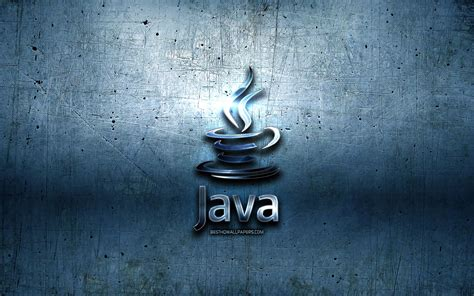

1


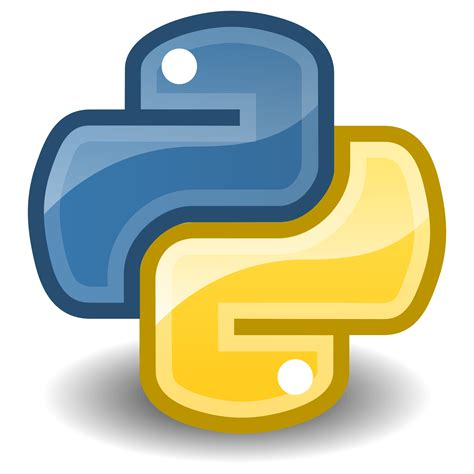

2


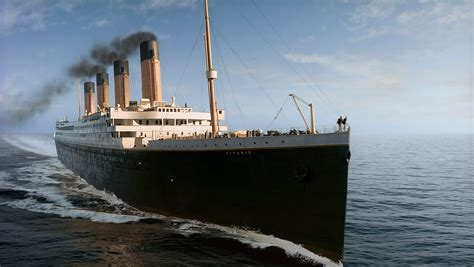

3


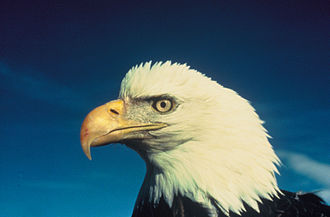

4


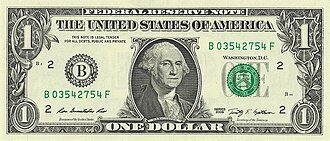

5


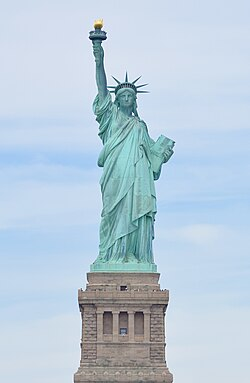

6


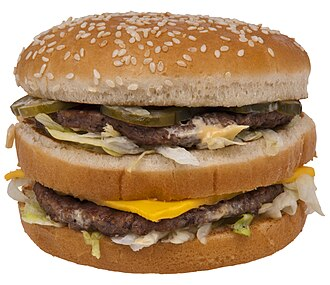


You typed: 1111

Next Phase

Given a cipher as query decode (not necessarily transcribe) it back to a country with countries(alphabet).
1


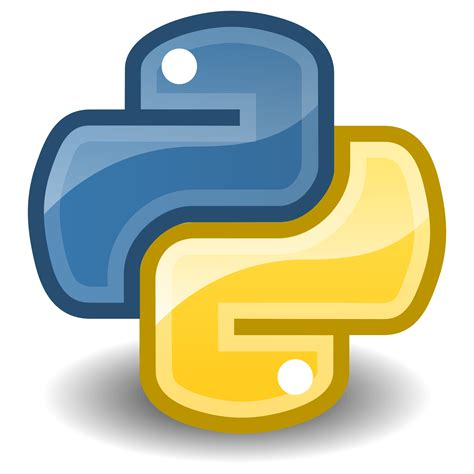

1


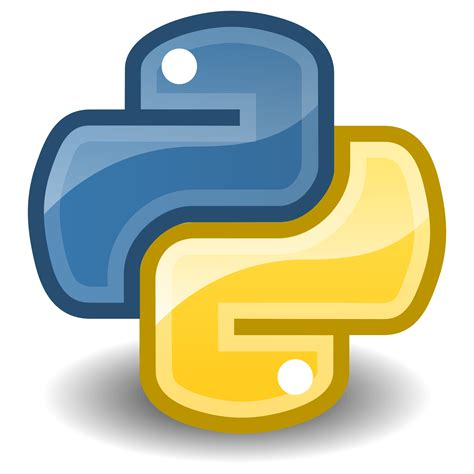

1


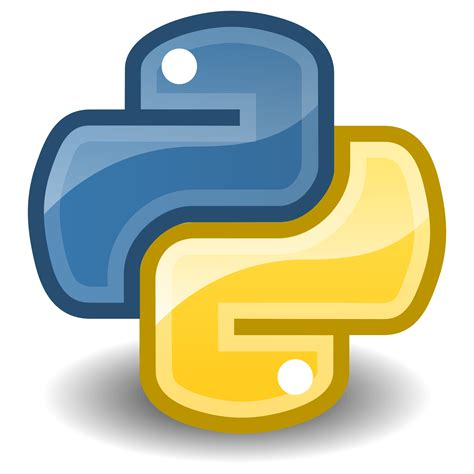

1


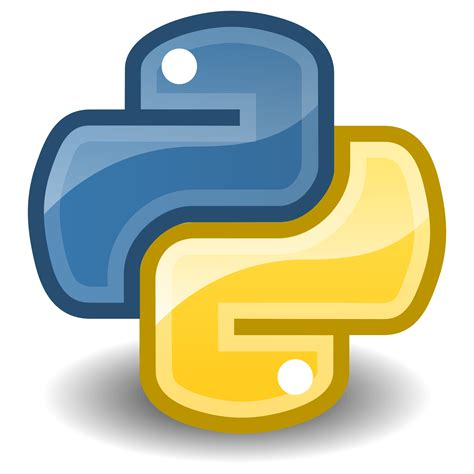


Valid is any single choice of the alphabet

Alphabet: 
['USA', 'Germany', 'France']

You typed: USA

Validator Phase
TODO

Query: USA

Valid is any word over the alphabet

Alphabet: 
['0', '1']

You typed: 1

received points: 1

Next Round

total points: 1


In [145]:
if __name__ == "__main__":
    emoji_alphabet = AlphabetType("emojis", ["❄️", "🛳️", "❤️", "💥", "🌊", "🧊", "💀", "🦈", "🚢", "🌹"])
    validator_alphabet = AlphabetType("Points", ["0", "1"])
    letter_alphabet = AlphabetType("lower_letters", list("abcdefghijklmnopqrstuvwxyz"))
    country_alphabet = AlphabetType("countries", ["USA", "Germany", "France"])
    image_alphabet = AlphabetType("images", {"0": load_local_image(Path("images/logoA.jpg")), "1": load_local_image(Path("images/logoB.jpg")), "2": load_local_image(Path("images/titanic.jpg")), "3": load_local_image(Path("images/usa_1.jpg"))
                                             , "4": load_local_image(Path("images/usa_2.jpg")), "5": load_local_image(Path("images/usa_3.jpg")), "6": load_local_image(Path("images/usa_4.jpg"))})

    separator = ""
    description_format = ("movie title", "emoji list", "lower case letters", "Points") # names of alphabets now in Alphabetclass

    examples = [
        Example("Titanic", emoji_alphabet, letter_alphabet, validator_alphabet),
        # Example("Inception", emoji_alphabet, letter_alphabet, validator_alphabet),
        # Example("Avatar", emoji_alphabet, letter_alphabet, validator_alphabet),
    ]
    task = Task(examples, separator, description_format)

#--------------------------------------------------------------------------------------------------------------------------#

    description_format_4i1w = description_format = ("country", "images", "countries", "Points")
    examples_4i1w = [
        Example("USA", image_alphabet, country_alphabet, validator_alphabet),
    ]
    task_4i1w = Task(examples_4i1w, separator, description_format_4i1w)

    #--------------------------------------------------------------------------------------------------------------------------#

    game = MyGame(
        task=task_4i1w,
        signature_encoder_cls=(MyMultipleChoiceSignature, MyHumanAdapter),
        signature_decoder_cls=[(MySingleChoiceSignature, MyHumanAdapter)],
        signature_validator_cls=(MyWordsSignature, MyHumanAdapter),
        agent_cls=MyAgent,
    )

    game.play_task()

In [ ]:
# TODO:
# code to .py, except main
# fix different signatures
# Seperator "" at unary letters
# Ranking given as list
# TODOS
#UI

In [ ]:
# ──────────────────────────────
# N Words


class MyWordsEncoder(WordsEncoder):
    def encode(self, cipher, encoder_alphabet) -> bool:
        symbols = regex.findall(r"\X", cipher)
        return all(c in encoder_alphabet for c in symbols)


# ──────────────────────────────
# N Words
# ──────────────────────────────


class MyNWordsEncoder(NWordsEncoder):
    def encode(self, cipher, encoder_alphabet) -> bool:
        symbols = regex.findall(r"\X", cipher)
        return all(c in encoder_alphabet for c in symbols) and len(symbols) <= n





# -----------------------------
# MultipleChoice
# -----------------------------
class MyMultipleChoiceEncoder(MultipleChoiceEncoder):
    def encode(self, cipher, encoder_alphabet) -> bool:
        symbols = regex.findall(r"\X", cipher)
        return all(c in encoder_alphabet for c in symbols)


# -----------------------------
# Permutation
# -----------------------------
class MyPermutationsAllEncoder(PermutationsAllEncoder):
    def encode(self, cipher, encoder_alphabet) -> bool:
        symbols = regex.findall(r"\X", cipher)
        return sorted(symbols) == sorted(encoder_alphabet)


# -----------------------------
# Variation
# -----------------------------
class MyPermutationsSubEncoder(PermutationsSubEncoder):
    def encode(self, cipher, encoder_alphabet) -> bool:
        symbols = regex.findall(r"\X", cipher)
        c1 = Counter(cipher)
        c2 = Counter(encoder_alphabet)
        return all(c1[x] <= c2[x] for x in c1) and len(c1) == len(encoder_alphabet)

NameError: name 'WordsEncoder' is not defined

In [ ]:
### chatbot methods


def load_local_image(path: Path) -> PImage.Image:
    """
    Load an image from disk as a PIL Image.
    """
    if not path.exists():
        raise FileNotFoundError(path)
    return PImage.open(path)
    
def show_alphabet(alphabet: AlphabetType): # shoud mabey work with lit as well
    """
    For each entry in the image alphabet, print the index
    and then display the corresponding image in the notebook.
    """
    for idx, pil_img in alphabet.indexed_letters.items():
        print(idx)
        display(pil_img)

def show_query(alphabet: AlphabetType, query: QueryType):
    """
    For a sequence like "0031", print the index and display
    the corresponding image for each character.
    """
    for index in query:
        if index not in alphabet.indexed_letters:
            raise KeyError(f"Index '{index}' not found in alphabet.")
        pil_img = alphabet.indexed_letters[index]
        print(index)
        display(pil_img)



def encode_image_base64(image: PImage.Image) -> str:
    """
    Encode a PIL Image as base64 JPEG.
    """
    buffer = BytesIO()
    image.convert("RGB").save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")


def get_message_text(response) -> str:
    return response.choices[0].message.content or ""


def send_request(payload: list[dict[str, any]]) -> str:  # TODO typehints
    """
    Send a single multimodal payload to the OpenAI-compatible chat API
    and return only the assistant's textual response.
    """

    client = OpenAI(
        base_url="https://chat.web.webis.de/openai/",  # "https://chat.web.webis.de/openai/" - with key or "https://llm.srv.webis.de/openai/v1/" in VPN
        api_key="sk-",
    )

    response = client.chat.completions.create(
        model="gemma3-4b",
        messages=[
            {
                "role": "user",
                "content": payload,
            }
        ],
        max_tokens=300,
    )

    return response


def build_multi_modal_payload(
    final_text: str,
    image_text_pairs: list[tuple[PImage.Image, str]] = [],
) -> list[dict[str, any]]:
    """
    Build a multimodal payload from optional image-text pairs and a final instruction.
    """

    payload  = []

    # Add image-text pairs if any
    for image, text in image_text_pairs:
        payload.append({"type": "text", "text": text})
        payload.append(
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encode_image_base64(image)}"
                },
            }
        )

    # Always add the final text
    payload.append({"type": "text", "text": final_text})

    return payload

[{'type': 'text', 'text': '1'}, {'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': '2'}, {'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': 'What is the term that these four images have in common? Choose a single option from the following list\n, '}]

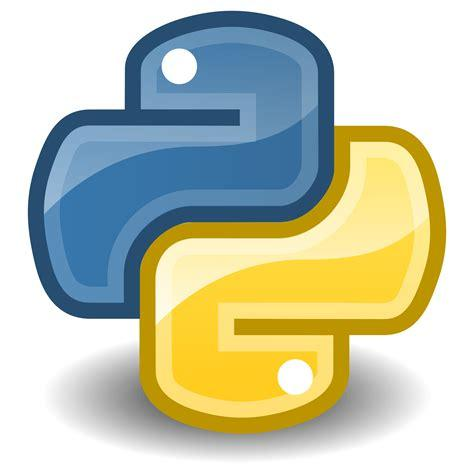
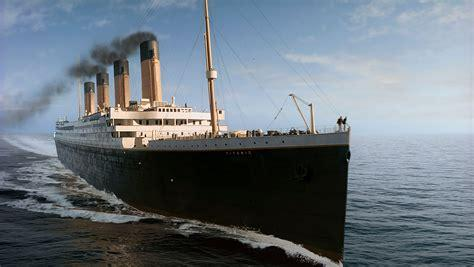

In [107]:
"""task = "Given a movie title as query, encode (not necessarily transcribe) it with symbols out of images (alphabet). \n\nValid is any single choice of the alphabet\nQuery: Titanic\nJust return the answer, nothing else"
payload = build_multi_modal_payload(image_text_pairs=[(image_alphabet.indexed_letters[k], k) for k in image_alphabet.indexed_letters], final_text=task)
response = send_request(payload)
get_message_text(response)

task = "What is the term that these four images have in common? Choose a single option from the following list" + "\n" + ", ".join((country_alphabet)) # [USA, Germany, France]
payload = build_multi_modal_payload(image_text_pairs=[(global_alphabet_buffer.indexed_letters[k], k) for k in global_alphabet_buffer.indexed_letters], final_text=task)
response = send_request(payload)
get_message_text(response)"""

query = "12"
task = "What is the term that these four images have in common? Choose a single option from the following list" + "\n" + ", " # [USA, Germany, France]
payload = build_multi_modal_payload(image_text_pairs=[(image_alphabet.indexed_letters[k], k) for k in list(query)], final_text=task)

print(payload)